In [ ]:
!git clone https://github.com/csteinmetz1/tempnetic.git
%cd tempnetic
!pip install -e .
%cd ..


fatal: destination path 'tempnetic' already exists and is not an empty directory.
/content/tempnetic
Obtaining file:///content/tempnetic
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tempnetic (pyproject.toml) ... done
  Created wheel for tempnetic: filename=tempnetic-0.0.1-0.editable-py3-none-any.whl size=11344 sha256=27f96553837d882d31adb444551fa7989a7ffc090d524394615ff8ff8247e29e
  Stored in directory: /tmp/pip-ephem-wheel-cache-b54iady3/wheels/d8/9d/63/69ead314a3927845a196ea62edd4960f801bc7b93c52225f17
Successfully built tempnetic
  Attempting uninstall: tempnetic
    Found existing installation: tempnetic 0.0.1
    Uninstalling tempnetic-0.0.1:
      Successfully uninstalled tempnetic-0.0.1
/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install omegaconf pytorch-lightning torchaudio torchlibrosa pedalboard


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)


Running on: cuda


In [ ]:

csv_path   = "/content/drive/MyDrive/Queen_Mary/Modules/Deep Learning for Audio/DL coursework/GTZAN dataset/features_30_sec.csv"
audio_root = "/content/drive/MyDrive/Queen_Mary/Modules/Deep Learning for Audio/DL coursework/GTZAN dataset/genres_original"


In [ ]:
import os
import csv
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
import torchaudio.functional as tF
import torch.nn.functional   as nnF


# make a dictionary with audio file names as keys and their labels as values
label_dict = {}
with open(csv_path, newline='') as f:
    for row in csv.DictReader(f):
        label_dict[row['filename']] = row['label']

# sort the labels dict by the genres and assign an integer to each genre, to facilitate the training
genres       = sorted(set(label_dict.values())) # create list of genres (set removes dupliactes)
label_to_idx = {g:i for i,g in enumerate(genres)} # create a dictionary with genres as keys and integers as values

# get lists of full file paths and their corresponding labels
all_files, all_labels = [], []
for filename, genre in label_dict.items():
    file_path = Path(audio_root) / genre / filename
    if not file_path.exists():
        continue
    all_files.append(str(file_path))  # add to list of file paths
    all_labels.append(label_to_idx[genre]) # add to list of labels

# set spectrogram parameter values
sr         = 22050
n_mels     = 64
n_fft      = int(0.05 * sr)   # 50 ms window
hop_length = int(0.025 * sr)  # 25 ms hop
num_frames = 400              # ≈10 s per spectrogram

# get specrtrograms using this transform from torchaudio
mel_spec = T.MelSpectrogram(
    sample_rate=sr,
    n_fft=n_fft,
    win_length=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)

specs = []
labels = []   # keep in sync with specs
valid_files = []
for file_path, label in zip(all_files, all_labels): # pair the two lists together in tuples with zip() to iterate over them in parallel
    try:
        waveform, sr = torchaudio.load(file_path)   # waveform is a torch.Tensor of shape [no. of channels, no. of audio samples] - in this case [1, T]
    except Exception as e:
        print(f"Skipping corrupted file {file_path!r}: {e}")
        continue

    # get mel spectrogram [1,64,T]
    spec = mel_spec(waveform)

    # convert to dB (still [1,64,T]), then squeeze (becomes [64,T])
    spec_db = tF.amplitude_to_DB(
        spec,
        multiplier=10.0,
        amin=1e-8,
        db_multiplier=torch.log10(spec.max())
    ).squeeze(0)

    # pad/truncate along time axis to exactly num_frames. output will be [64, num_frames]
    Tcur = spec_db.shape[1]
    if Tcur < num_frames:
        spec_db = torch.nn.functional.pad(spec_db, (0, num_frames - Tcur))
    else:
        spec_db = spec_db[:, :num_frames]

    specs.append(spec_db.numpy())
    labels.append(label)
    valid_files.append(file_path)

# stack into a single array & turn into torch.Tensor [N,1,64,num_frames] where N is the number of audio files
all_specs   = np.stack(specs, axis=0).astype('float32')  # (N,64,400)
data_tensor = torch.from_numpy(all_specs).unsqueeze(1)   # (N,1,64,400). unsqueeze to add a channel dimension for compatibility with CNNs

# make labels tensor of shape [N,]
labels_tensor = torch.tensor(labels, dtype=torch.long) # torch.long needed for compatibility with nn.CrossEntropyLoss

import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

specs_arr  = np.stack(specs, axis=0).astype('float32')  # (N,64,400)
labels_arr = np.array(labels)                           # (N,)
files_arr  = np.array(valid_files)                        # (N,)

# First split off 20% for TEST
specs_trainval, specs_test, \
labels_trainval, labels_test, \
files_trainval,  files_test = train_test_split(
    specs_arr, labels_arr, files_arr,
    test_size=0.20,
    stratify=labels_arr,
    random_state=42
)

# Then split remaining 80% into TRAIN (60%) and VAL (20%)
specs_train, specs_val, \
labels_train, labels_val, \
files_train,  files_val = train_test_split(
    specs_trainval, labels_trainval, files_trainval,
    test_size=0.25,   # 0.25 * 0.80 = 0.20 total
    stratify=labels_trainval,
    random_state=42
)

# Convert back to tensors, add channel dim
X_train = torch.from_numpy(specs_train).unsqueeze(1)   # [N_train,1,64,400]
X_val   = torch.from_numpy(specs_val).unsqueeze(1)
X_test  = torch.from_numpy(specs_test).unsqueeze(1)

y_train = torch.tensor(labels_train, dtype=torch.long)
y_val   = torch.tensor(labels_val,   dtype=torch.long)
y_test  = torch.tensor(labels_test,  dtype=torch.long)

train_files = files_train.tolist()
val_files   = files_val.tolist()
test_files  = files_test.tolist()

# sanity check
print("Train:", X_train.shape, len(train_files))
print("Val:  ", X_val.shape,   len(val_files))
print("Test: ", X_test.shape,  len(test_files))

Skipping corrupted file '/content/drive/MyDrive/Queen_Mary/Modules/Deep Learning for Audio/DL coursework/GTZAN dataset/genres_original/jazz/jazz.00054.wav': Failed to open the input "/content/drive/MyDrive/Queen_Mary/Modules/Deep Learning for Audio/DL coursework/GTZAN dataset/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7f11e81b41b6 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7f11e815da76 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42034 (0x7f10b6cb8034 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::

In [ ]:

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=batch_size,
                          shuffle=True,  num_workers=4)
valid_loader = DataLoader(TensorDataset(X_val,   y_val),
                          batch_size=batch_size,
                          shuffle=False, num_workers=4)
test_loader  = DataLoader(TensorDataset(X_test,  y_test),
                          batch_size=batch_size,
                          shuffle=False, num_workers=4)

In [ ]:
class CnnModel(nn.Module):
    """The CNN model"""
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(5, 5), bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), padding=(2, 0)), # the first dimension is the time axis, the second is the frequency axis
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), padding=(2, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Flatten(),
            nn.Linear(in_features=2816, out_features=128, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10, bias=True), # 10 neurons, one for each genre
        )

        self.apply(self._init_weights)


    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.BatchNorm2d):
            torch.nn.init.ones_(module.weight)


    def forward(self, x):
        return self.model(x)

In [ ]:
# create a model instance
model = CnnModel().to(device)
print(model)

criterion = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.)

CnnModel(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=(2, 0), dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=(2, 1), dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2816, out_features=128, bias=True)
    (14): ReLU()
    (15): Linear(

In [ ]:
def evaluate(model, data_loader: DataLoader, criterion, device):
    """
    Evaluate the model on validation or test data.
    Returns average loss and accuracy.
    """
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


def train(model, train_loader: DataLoader, valid_loader: DataLoader,
          criterion, optimizer, num_epochs: int, device,
          saved_model_path: str, evaluate_every: int = 1):
    """
    Train the model and periodically evaluate on validation data.
    Saves the best model by validation accuracy.
    Returns a history dict with train/val losses and val accuracy.
    """
    model.to(device)
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [],'valid_loss': [], 'valid_acc': []}

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds          = outputs.argmax(dim=1)
            correct_train += (preds == labels).sum().item()
            total_train   += inputs.size(0)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc  = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc {epoch_train_acc*100:.2f}%")


        if epoch % evaluate_every == 0:
            val_loss, val_acc = evaluate(model, valid_loader, criterion, device)
            history['valid_loss'].append(val_loss)
            history['valid_acc'].append(val_acc)
            print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), saved_model_path)
                print(f"  Saved best model with Val Acc: {val_acc*100:.2f}%")

    return history

In [ ]:
# assuming your model is already defined as above:
model = CnnModel()
# grab just the convolutional backbone (everything up to Flatten)
backbone = nn.Sequential(*list(model.model.children())[:-4])
# (-4 because the last 4 layers are Flatten, Linear, ReLU, Linear)

# make a dummy batch of size 1 with your spectrogram shape [1,1,64,400]
x_dummy = torch.zeros(1,1,64,400)
with torch.no_grad():
    h = backbone(x_dummy)
print(h.shape)
# e.g. torch.Size([1, 128, H', W'])

# now you know H',W'; the flattened size is 128*H'*W'
flat_size = h.numel() // h.shape[0]
print("Flattened feature size:", flat_size)


torch.Size([1, 128, 1, 22])
Flattened feature size: 2816


In [ ]:
model = CnnModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
history = train(
    model,
    train_loader,
    valid_loader,
    criterion,
    optimizer,
    num_epochs=30,
    device=device,
    saved_model_path='/content/drive/MyDrive/best_cnn2.pth',
    evaluate_every=1
)


Epoch 1/30 - Train Loss: 2.1148, Train Acc 27.05%
  Val Loss: 3.0918 | Val Acc: 20.00%
  Saved best model with Val Acc: 20.00%
Epoch 2/30 - Train Loss: 1.3057, Train Acc 52.75%
  Val Loss: 1.4029 | Val Acc: 51.00%
  Saved best model with Val Acc: 51.00%
Epoch 3/30 - Train Loss: 0.8758, Train Acc 70.12%
  Val Loss: 1.5139 | Val Acc: 45.50%
Epoch 4/30 - Train Loss: 0.5812, Train Acc 79.80%
  Val Loss: 1.1209 | Val Acc: 60.00%
  Saved best model with Val Acc: 60.00%
Epoch 5/30 - Train Loss: 0.4645, Train Acc 83.97%
  Val Loss: 1.0439 | Val Acc: 60.00%
Epoch 6/30 - Train Loss: 0.3091, Train Acc 91.65%
  Val Loss: 1.5961 | Val Acc: 57.50%
Epoch 7/30 - Train Loss: 0.1607, Train Acc 96.83%
  Val Loss: 1.2696 | Val Acc: 58.50%
Epoch 8/30 - Train Loss: 0.1053, Train Acc 98.33%
  Val Loss: 0.9691 | Val Acc: 68.50%
  Saved best model with Val Acc: 68.50%
Epoch 9/30 - Train Loss: 0.0651, Train Acc 98.66%
  Val Loss: 1.1219 | Val Acc: 61.50%
Epoch 10/30 - Train Loss: 0.0465, Train Acc 99.17%
  Val 

In [ ]:
genre_model = CnnModel().to(device)
genre_model.load_state_dict(torch.load("/content/drive/MyDrive/Queen Mary/Modules/DL coursework/best_cnn.pth", map_location=device))
genre_model.eval()

CnnModel(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=(2, 0), dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=(2, 1), dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2816, out_features=128, bias=True)
    (14): ReLU()
    (15): Linear(

In [ ]:
# Get the test set accuracy

criterion = torch.nn.CrossEntropyLoss()

running_loss = 0.0
correct      = 0
total        = 0

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        logits = model(Xb)
        loss   = criterion(logits, yb)

        running_loss += loss.item() * Xb.size(0)
        preds        = logits.argmax(dim=1)
        correct     += (preds == yb).sum().item()
        total       += yb.size(0)

test_loss = running_loss / total
test_acc  = correct / total

print(f"Genre Test  →  Loss: {test_loss:.4f},  Acc: {test_acc*100:.2f}%")

Genre Test  →  Loss: 1.2148,  Acc: 70.00%


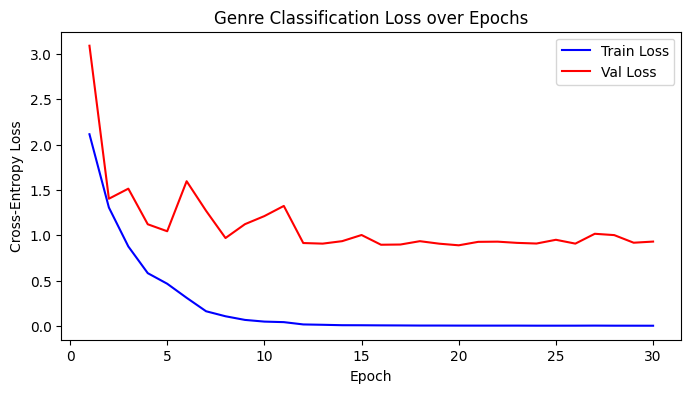

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


def plot_genre_training(history):
    epochs = np.arange(1, len(history['train_loss'])+1)
    # how many val points do we actually have?
    n_val   = len(history['valid_loss'])

    plt.figure(figsize=(8,4))
    plt.plot(epochs, history['train_loss'],  'b-', label='Train Loss')
    if n_val>0:
        # only plot val for the first n_val epochs
        plt.plot(epochs[:n_val], history['valid_loss'], 'r-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross‐Entropy Loss')
    plt.title('Genre Classification Loss over Epochs')
    plt.legend()
    plt.show()

plot_genre_training(history)


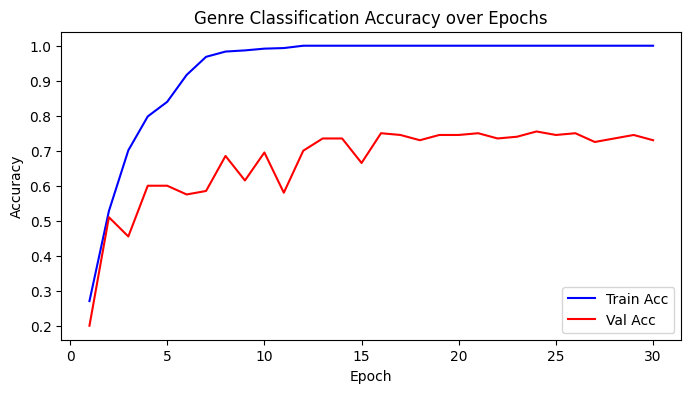

In [ ]:
def plot_genre_accuracy(history):
    epochs = np.arange(1, len(history['train_acc'])+1)
    n_val   = len(history['valid_acc'])

    plt.figure(figsize=(8,4))
    plt.plot(epochs, history['train_acc'],  'b-', label='Train Acc')
    if n_val>0:
        plt.plot(epochs[:n_val], history['valid_acc'], 'r-', label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Genre Classification Accuracy over Epochs')
    plt.legend()
    plt.show()

plot_genre_accuracy(history)

In [ ]:
!git clone https://github.com/csteinmetz1/tempnetic.git
%cd tempnetic
!pip install -e .
%cd ..


fatal: destination path 'tempnetic' already exists and is not an empty directory.
/content/tempnetic
Obtaining file:///content/tempnetic
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tempnetic (pyproject.toml) ... done
  Created wheel for tempnetic: filename=tempnetic-0.0.1-0.editable-py3-none-any.whl size=11344 sha256=066f1b3d7e77c75525df0146be9fddd7e32087095630adef8702f06451accd32
  Stored in directory: /tmp/pip-ephem-wheel-cache-ezjvdj5y/wheels/d8/9d/63/69ead314a3927845a196ea62edd4960f801bc7b93c52225f17
Successfully built tempnetic
  Attempting uninstall: tempnetic
    Found existing installation: tempnetic 0.0.1
    Uninstalling tempnetic-0.0.1:
      Successfully uninstalled tempnetic-0.0.1


/content


In [ ]:
!pip install omegaconf
%pip install pedalboard

In [ ]:

from omegaconf import OmegaConf
from pytorch_lightning import Trainer

from tempnetic.data      import AudioFileDataModule
from tempnetic.models.panns import Cnn14
from tempnetic.system    import System



In [ ]:

# Load all three config files into Python objects
trainer_cfg    = OmegaConf.load("tempnetic/cfg/trainer.yaml")
full_data_cfg  = OmegaConf.load("tempnetic/cfg/data.yaml")
full_model_cfg = OmegaConf.load("tempnetic/cfg/models/panns.yaml")


In [ ]:
import os
print(os.getcwd(), os.listdir("tempnetic/cfg"))

/content ['data.yaml', 'trainer.yaml', 'models']


In [ ]:


from torch.utils.data import Dataset

# Define the Dataset
class TempoDataset(Dataset):
    def __init__(self, file_list, tempo_dict, target_samples=30*22050):
        self.files          = file_list
        self.tempo_dict     = tempo_dict
        self.target_samples = target_samples

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fp = self.files[idx]
        wav, sr = torchaudio.load(fp)           # [1, T]
        # pad/trunc to fixed length
        Tcur = wav.size(1)
        if Tcur < self.target_samples:
            wav = torch.nn.functional.pad(wav, (0, self.target_samples - Tcur))
        else:
            wav = wav[:, :self.target_samples]
        tempogram = torch.zeros(1,1)            # dummy, since use_tempogram=False
        bpm       = torch.tensor(
                       [self.tempo_dict[Path(fp).name]],
                       dtype=torch.float32
                    )                      # [1]
        return wav, tempogram, bpm


import csv
tempo_dict = {}
with open(csv_path, newline='') as f:
    for row in csv.DictReader(f):
        tempo_dict[row['filename']] = float(row['tempo'])  # adjust if column name differs

# Instantiate your train/val tempo datasets
ds_train = TempoDataset(train_files, tempo_dict)
ds_val   = TempoDataset(val_files,   tempo_dict)

# Wrap into DataLoaders
from torch.utils.data import DataLoader

train_loader = DataLoader(ds_train,
                          batch_size=16,
                          shuffle=True,
                          num_workers=2)
valid_loader = DataLoader(ds_val,
                          batch_size=16,
                          shuffle=False,
                          num_workers=2)


In [ ]:
# Train PANNs Tempo Estimator


from pathlib import Path
from torch.utils.data import Dataset, DataLoader


from tempnetic.models.panns import Cnn14
from tempnetic.system       import System
import torch.nn as nn

# Unpack your configs (you already have full_model_cfg and system_args)
model_block    = full_model_cfg.model
system_args    = dict(model_block.init_args)
backbone_block = system_args.pop("model")
backbone_args  = dict(backbone_block.init_args)

# Build the raw PANN backbone
raw_backbone = Cnn14(**backbone_args)

# Wrap it so it swallows the 'tempogram' kwarg
class BackboneWrapper(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
    def forward(self, x, tempogram=None):
        return self.backbone(x)

backbone = BackboneWrapper(raw_backbone)

# Finally instantiate the System with the wrapped backbone
system = System(backbone, **system_args)

from pytorch_lightning.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    verbose=True
)


from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# Early‐stop on no val_loss improvement for 10 epochs
early_stop = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10,
    verbose=True
)

# Save only the single best checkpoint (lowest val_loss)
ckpt_cb = ModelCheckpoint(
    dirpath="tempo_checkpoints",
    filename="best_tempo",
    monitor="val_loss",
    mode="min",
    save_top_k=1
)

# Build your Trainer with both callbacks
trainer = Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    max_epochs=50,
    precision=trainer_cfg.trainer.precision,
    callbacks=[early_stop, ckpt_cb],
    default_root_dir=trainer_cfg.trainer.default_root_dir,

)

# Fit as before
trainer.fit(
    system,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader
)

print("→ Saved best checkpoint at:", ckpt_cb.best_model_path)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | BackboneWrapper | 79.7 M | train
--------------------------------------------------
75.5 M    Trainable params
4.3 M     Non-trainable params
79.7 M    Total params
318.974   Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.078


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.043


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.028. Signaling Trainer to stop.


→ Saved best checkpoint at: /content/tempo_checkpoints/best_tempo.ckpt


In [ ]:
import torch
from tempnetic.models.panns import Cnn14
from tempnetic.system       import System
from omegaconf               import OmegaConf

# Rebuild your un-wrapped backbone & system args
model_cfg     = OmegaConf.load("tempnetic/cfg/models/panns.yaml")
system_args   = dict(model_cfg.model.init_args)
backbone_args = dict(system_args.pop("model").init_args)

backbone      = Cnn14(**backbone_args)
tempo_system  = System(backbone, **system_args)

# Load the raw checkpoint
ckpt = torch.load("tempo_checkpoints/best_tempo.ckpt", map_location="cpu")
state = ckpt["state_dict"]  # this is the dict with the 'model.backbone...' keys

# Remap keys: drop the extra 'backbone.' segment
new_state = {}
for k,v in state.items():
    if k.startswith("model.backbone."):
        new_key = "model." + k[len("model.backbone."):]
    else:
        new_key = k
    new_state[new_key] = v

# Load into your System and switch to eval
tempo_system.load_state_dict(new_state)
tempo_system.eval()


System(
  (model): Cnn14(
    (spectrogram_extractor): Spectrogram(
      (stft): STFT(
        (conv_real): Conv1d(1, 1025, kernel_size=(2048,), stride=(1024,), bias=False)
        (conv_imag): Conv1d(1, 1025, kernel_size=(2048,), stride=(1024,), bias=False)
      )
    )
    (logmel_extractor): LogmelFilterBank()
    (spec_augmenter): SpecAugmentation(
      (time_dropper): DropStripes()
      (freq_dropper): DropStripes()
    )
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_block1): ConvBlock(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel

Overall Tempo MAE: 25.24 BPM, MedAE: 17.95 BPM



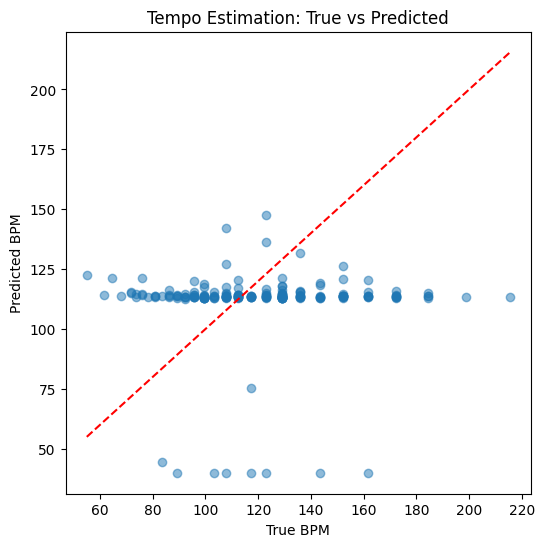

In [ ]:


import torch
import torch.nn as nn
from omegaconf           import OmegaConf
from tempnetic.models.panns import Cnn14
from tempnetic.system       import System

# Re-define the tiny wrapper you used during training
class BackboneWrapper(nn.Module):
    def __init__(self, backbone: nn.Module):
        super().__init__()
        self.backbone = backbone

    def forward(self, x, tempogram=None):
        # swallow the dummy second argument
        return self.backbone(x)

# Load your YAML so you can reconstruct the init args
model_cfg     = OmegaConf.load("tempnetic/cfg/models/panns.yaml")
system_args   = dict(model_cfg.model.init_args)
backbone_args = dict(system_args.pop("model").init_args)

# Rebuild the wrapped backbone
raw_backbone = Cnn14(**backbone_args)
wrapped_backbone = BackboneWrapper(raw_backbone)

# Instantiate your Lightning System exactly as in training
tempo_system = System(wrapped_backbone, **system_args)

# Load checkpoint
ckpt = torch.load("tempo_checkpoints/best_tempo.ckpt", map_location="cpu")
tempo_system.load_state_dict(ckpt["state_dict"])

tempo_system.eval().to(device)




# Evaluate on test split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Make your test‐split loader exactly as before
ds_test_tempo = TempoDataset(test_files, tempo_dict)
loader_tempo  = DataLoader(ds_test_tempo, batch_size=16, shuffle=False, num_workers=4)

all_preds, all_truths, all_genres = [], [], []
with torch.no_grad():
    for wav, tempogram, truth_bpm in loader_tempo:
        wav       = wav.to(device)
        tempogram = tempogram.to(device)

        # Now your wrapped model can accept the second arg
        scaled = tempo_system(wav, tempogram)   # in [0,1]
        bpm_pred = scaled * (system_args["max_bpm"] - system_args["min_bpm"]) \
                   + system_args["min_bpm"]

        all_preds .extend(bpm_pred.squeeze().cpu().tolist())
        all_truths.extend(truth_bpm.squeeze().tolist())
        all_genres.extend([Path(fp).parent.name for fp in ds_test_tempo.files])

# Compute & print metrics
preds  = np.array(all_preds)
truths = np.array(all_truths)
mae    = np.mean(np.abs(preds-truths))
medae  = np.median(np.abs(preds-truths))
print(f"Overall Tempo MAE: {mae:.2f} BPM, MedAE: {medae:.2f} BPM\n")



# Scatter true vs. predicted
plt.figure(figsize=(6,6))
plt.scatter(truths, preds, alpha=0.5)
mn, mx = truths.min(), truths.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True BPM"); plt.ylabel("Predicted BPM")
plt.title("Tempo Estimation: True vs Predicted")
plt.show()


In [ ]:
def predict_bpms(file_list, tempo_system, batch_size=16):
    ds = TempoDataset(file_list, tempo_dict)
    loader = DataLoader(ds, batch_size, shuffle=False, num_workers=4)
    bpm_preds = []
    with torch.no_grad():
        for wav, _, _ in loader:
            wav = wav.to(device)
            scaled = tempo_system(wav)
            bpm    = scaled * (system_args['max_bpm']-system_args['min_bpm']) \
                   + system_args['min_bpm']
            bpm_preds.extend(bpm.squeeze().cpu().tolist())
    return bpm_preds

train_bpms = predict_bpms(train_files, tempo_system)
val_bpms   = predict_bpms(val_files,   tempo_system)
test_bpms  = predict_bpms(test_files,  tempo_system)


In [ ]:
import torch.nn as nn

# Rebuild & load your genre CNN up to its penultimate layer:
base = CnnModel()
base.load_state_dict(torch.load('/content/drive/MyDrive/Queen Mary/Modules/DL coursework/best_cnn.pth', map_location=device))


feat_extractor = nn.Sequential(*list(base.model.children())[:-1])  # now maps → [batch,128]

# Freeze all conv & batch‐norm layers
for m in feat_extractor.modules():
    if isinstance(m, (nn.Conv2d, nn.BatchNorm2d)):
        for p in m.parameters():
            p.requires_grad = False


In [ ]:
class FusedGenreModel(nn.Module):
    def __init__(self, feat_extractor, embed_size=128, n_classes=10):
        super().__init__()
        self.fe = feat_extractor       # outputs [B,128]
        # after concatenating one scalar BPM:
        self.fc1 = nn.Linear(embed_size + 1, embed_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embed_size, n_classes)

    def forward(self, x, bpm):
        z = self.fe(x)                     # [B,128]
        bpm = bpm.view(-1,1).to(z.dtype)   # [B,1]
        f = torch.cat([z, bpm], dim=1)     # [B,129]
        h = self.relu(self.fc1(f))         # [B,128]
        return self.fc2(h)                 # [B,10]


In [ ]:
from torch.utils.data import Dataset, DataLoader

class CombinedDataset(Dataset):
    def __init__(self, specs, bpms, labels):
        self.X      = specs      # your torch tensor [N,1,64,400]
        self.bpms   = bpms       # Python list length N
        self.labels = labels     # torch.Tensor length N

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return self.X[i], torch.tensor(self.bpms[i],dtype=torch.float32), self.labels[i]

train_ds = CombinedDataset(X_train, train_bpms, y_train)
val_ds   = CombinedDataset(X_val,   val_bpms,   y_val)
test_ds  = CombinedDataset(X_test,  test_bpms,  y_test)

train_loader_f = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
val_loader_f   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4)
test_loader_f  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_f = FusedGenreModel(feat_extractor).to(device)

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_f.parameters()),
    lr=1e-3
)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
for epoch in range(1, 31):
    # — train —
    model_f.train()
    running, corr, tot = 0,0,0
    for x, bpm, y in train_loader_f:
        x, bpm, y = x.to(device), bpm.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model_f(x, bpm)
        loss   = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running += loss.item() * x.size(0)
        preds   = logits.argmax(dim=1)
        corr   += (preds==y).sum().item()
        tot    += y.size(0)

    train_loss = running/tot
    train_acc  = corr/tot

    # — validate —
    model_f.eval()
    val_running, val_corr, val_tot = 0,0,0
    with torch.no_grad():
        for x, bpm, y in val_loader_f:
            x, bpm, y = x.to(device), bpm.to(device), y.to(device)
            logits = model_f(x, bpm)
            loss   = criterion(logits, y)
            val_running += loss.item()*x.size(0)
            p = logits.argmax(dim=1)
            val_corr   += (p==y).sum().item()
            val_tot    += y.size(0)

    val_loss = val_running/val_tot
    val_acc  = val_corr/val_tot
    print(f"Epoch {epoch:02d} — train_acc {train_acc:.3f}, val_acc {val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_f.state_dict(), 'best_fused.pth')


Epoch 01 — train_acc 0.399, val_acc 0.520
Epoch 02 — train_acc 0.825, val_acc 0.705
Epoch 03 — train_acc 0.925, val_acc 0.735
Epoch 04 — train_acc 0.987, val_acc 0.710
Epoch 05 — train_acc 0.995, val_acc 0.740
Epoch 06 — train_acc 1.000, val_acc 0.730
Epoch 07 — train_acc 0.997, val_acc 0.750
Epoch 08 — train_acc 1.000, val_acc 0.715
Epoch 09 — train_acc 0.998, val_acc 0.745
Epoch 10 — train_acc 1.000, val_acc 0.715
Epoch 11 — train_acc 1.000, val_acc 0.715
Epoch 12 — train_acc 1.000, val_acc 0.730
Epoch 13 — train_acc 1.000, val_acc 0.710
Epoch 14 — train_acc 1.000, val_acc 0.720
Epoch 15 — train_acc 1.000, val_acc 0.720
Epoch 16 — train_acc 1.000, val_acc 0.715
Epoch 17 — train_acc 1.000, val_acc 0.735
Epoch 18 — train_acc 1.000, val_acc 0.725
Epoch 19 — train_acc 1.000, val_acc 0.720
Epoch 20 — train_acc 1.000, val_acc 0.720
Epoch 21 — train_acc 1.000, val_acc 0.710
Epoch 22 — train_acc 1.000, val_acc 0.710
Epoch 23 — train_acc 1.000, val_acc 0.725
Epoch 24 — train_acc 1.000, val_ac

In [46]:
model_f.load_state_dict(torch.load('best_fused.pth', map_location=device))
model_f.eval()

corr, tot = 0,0
with torch.no_grad():
    for x, bpm, y in test_loader_f:
        x, bpm, y = x.to(device), bpm.to(device), y.to(device)
        p = model_f(x, bpm).argmax(dim=1)
        corr += (p==y).sum().item()
        tot  += y.size(0)

print(f"Fused model test  →  Acc: {corr/tot*100:.2f}%")
print(f"  ▶  Genre‐only baseline: {test_acc*100:.2f}%")


Fused model test  →  Acc: 68.00%
  ▶  Genre‐only baseline: 70.00%
